# Chains in LangChain

## Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  * SequentialChain
* Router Chain

In [ ]:
#!pip install pandas

In [2]:
import pandas as pd
df = pd.read_csv('data/Product_Review.csv')

In [3]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


## LLMChain

In [4]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [5]:
# high temperature get fun response
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")

In [6]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [8]:
chain = prompt | llm

In [11]:
product = "Queen Size Sheet Set"
chain.invoke(product).content

'"Royal Linens"'

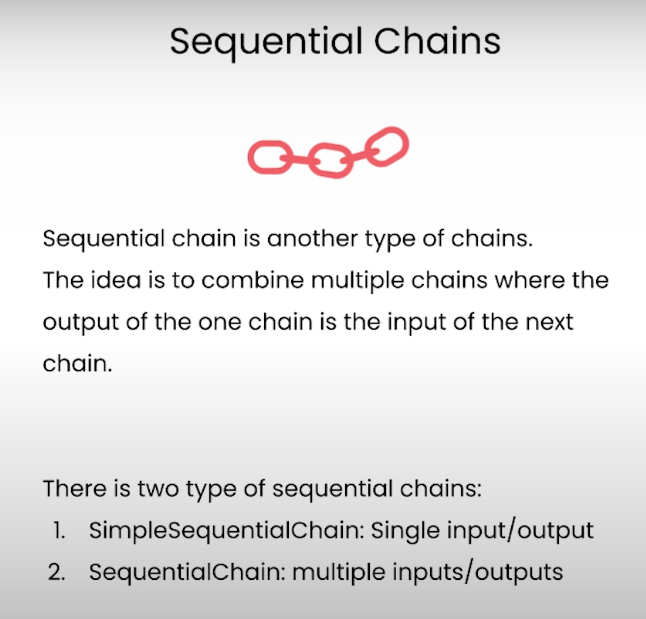

## SimpleSequentialChain

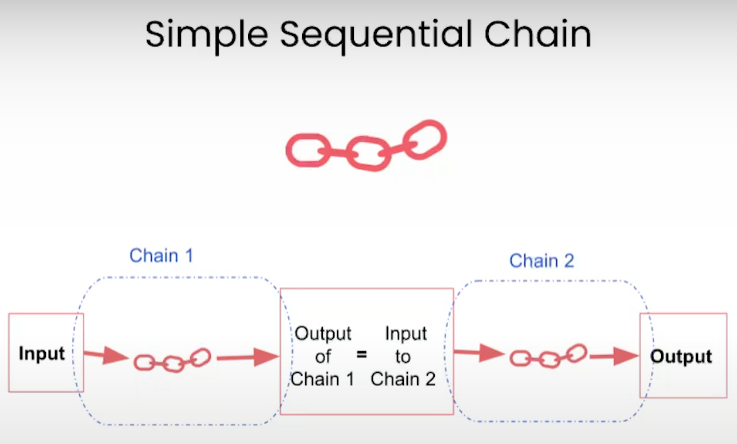

In [12]:
from langchain.chains import SimpleSequentialChain

In [13]:
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [14]:
# Output of the first chain: company_name will be pass to the second chain

# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [15]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [17]:
overall_simple_chain.invoke(product)



> Entering new SimpleSequentialChain chain...
"Royal Comfort Linens"
Royal Comfort Linens provides luxurious and high-quality bedding and bathroom essentials to elevate your home with sophisticated style and comfort.

> Finished chain.


{'input': 'Queen Size Sheet Set',
 'output': 'Royal Comfort Linens provides luxurious and high-quality bedding and bathroom essentials to elevate your home with sophisticated style and comfort.'}

## SequentialChain

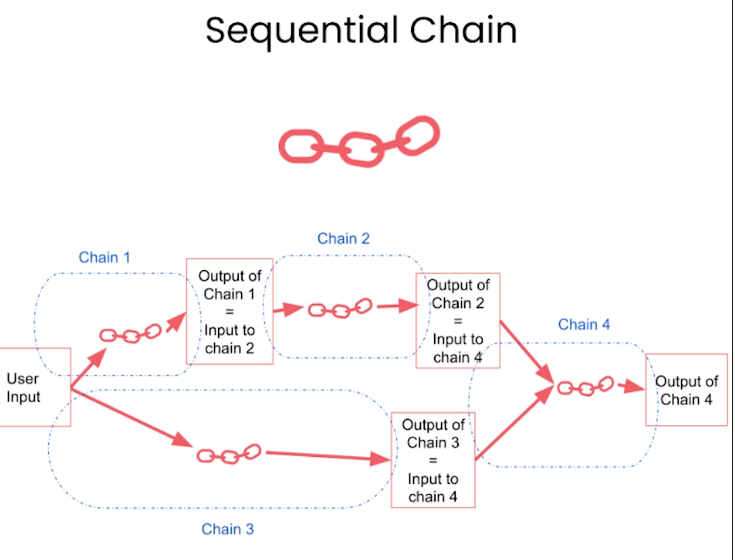

In [18]:
from langchain.chains import SequentialChain

In [19]:
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )


In [20]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [21]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


In [22]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [23]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [25]:
review = df.Review[5]
overall_chain.invoke(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'English_Review': "I find the taste poor. The foam doesn't hold, it's strange. I buy the same ones in stores and the taste is much better... Old batch or counterfeit!?",
 'summary': 'The reviewer expresses disappointment in the poor taste and lack of foam retention in the product, suggesting the possibility of receiving an old batch or counterfeit item.',
 'followup_message': "Nous sommes désolés d'apprendre que vous avez été déçu par notre produit. Nous vous assurons que nous prenons la qualité de nos produits très au sérieux et nous examinerons de plus près cette question. Il est possible que vous ayez reçu un lot ancien ou contrefait. Nous vous remercions de nous avoir informés de cette situation et ferons de notre mieux pour rectifier le problème."}

## Router Chain

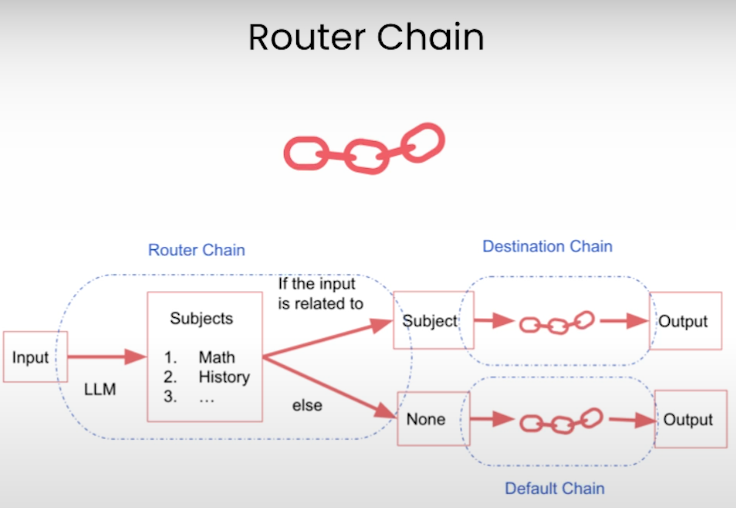

In [26]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [27]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [42]:
# Specific type of chain is used when routing between
# multiple different prompt templates
from langchain.chains.router import MultiPromptChain

# LLMRouteChain - use LLM itself to route between different subchain
# This is where the description and the name provided above will be used

# RouterOutput - Parses the LLM outuput in to the dictionary can be used
# downstream to determine whcih chain oto use and what the input to that chain should be
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [43]:
llm = ChatOpenAI(temperature=0, model="gpt-4-turbo")

In [44]:

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [45]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [46]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [47]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [48]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True,
                        #  silent_errors=True
                        )

In [49]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


"Black body radiation refers to the type of electromagnetic radiation (which includes visible light, infrared light, ultraviolet light, etc.) emitted by an idealized object called a black body. A black body is an idealized physical body that absorbs all incident electromagnetic radiation, regardless of frequency or angle of incidence. That is, it is a perfect absorber (and emitter) of radiation.\n\nThe significance of black body radiation lies in its spectrum or distribution of radiation intensity versus wavelength, which depends only on the body's temperature. This characteristic makes it a fundamental reference for the study of electromagnetic radiation.\n\nThe concept of black body radiation was crucial in the development of quantum mechanics. Classical physics could not explain why the intensity of radiation emitted by a black body differed at different wavelengths, and why it did not infinitely increase at shorter wavelengths (a problem known as the ultraviolet catastrophe). Max P

In [40]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'The answer to 2 + 2 is 4.'

In [50]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...
None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


'Every cell in our body contains DNA because it serves as the fundamental blueprint for all biological functions and structures within an organism. DNA, or deoxyribonucleic acid, carries the genetic instructions used in the growth, development, functioning, and reproduction of all known living organisms and many viruses. Here are some key reasons why DNA is present in every cell:\n\n1. **Genetic Blueprint**: DNA contains the instructions needed to build and maintain an organism. It encodes the genes that determine everything from the color of our eyes to our susceptibility to certain diseases.\n\n2. **Protein Synthesis**: DNA is crucial for the process of protein synthesis. Proteins are essential molecules that serve a wide variety of functions in the body, such as catalyzing metabolic reactions, replicating DNA, responding to stimuli, and transporting molecules. The process of transcription (where DNA is converted into RNA) and translation (where RNA is used to produce proteins) is fu